# Tap find and align
A notebook to evaluate device time offsets in equivital vest measurements during the Bodies in Concert recordings with the Stavangar orchestra. 

1. This notebook loads the fast accelerometer data from a set of concurrent ACC measurements, resamples and compares to a tapping cue template to offer an initial alignment.
2. Alignments are then checked and corrected with cross correlation information and saved
3. Alignment across concurrent recordings are ploted and assessed for quality and device reliability
4. TODO: Alignments are finally checked against other well timed moments in the concerts

Some of this notebook can be used to check the AX3 recordings and MS data when these are available.

In [15]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [16]:
%load_ext autoreload
%autoreload 1
%aimport qex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%reload_ext autoreload

In [18]:
def tap_cue_align(cue,sig_ex,sig_ID):
    # a function to take a segment of signal and the tapping cue to determing
    # the best shift value would allow alignment of signal to cue
    signal = sig_ex.copy()
        # make the signal excerpt corr compatible. Inclusing cutting the extreme peaks
    signal[signal.isna()] = 0
    M = signal.quantile(0.998)
    signal = signal/M
    signal[signal>1] = 1
    
    # cue must be sampled at the same steady rate as the signal exerpt
    sampleshift_s = cue.index.to_series().diff().median()
    length = np.min([len(signal),len(cue)])
    
    if signal.diff().abs().sum()<0.1: # signal is flat
        shifts.append(np.nan)
        print('sig_ex is too flat.')
        return
    else:
        fig = plt.figure(figsize=(15,6))
        ax1 = plt.subplot(311)
        signal.plot(label=sig_ID,ax=ax1,)
        cue.plot.line(y='cue',ax=ax1)
        ax1.set_title(sig_ID + ' synch alignment')
        ax1.legend()
        #plt.xlim(cue_range)
        
        ax2 = plt.subplot(312)
        CCC = ax2.xcorr(cue['cue'].iloc[:length], signal.iloc[:length], usevlines=True, maxlags=length-1, normed=True, lw=3)
        ax2.grid(True)
        ax2.set_xticklabels('')
        signal.index = signal.index + sampleshift_s*CCC[0][np.argmax(CCC[1])]
        
        ax1 = plt.subplot(313)
        signal.plot(label=sig_ID,ax=ax1,)
        cue.plot.line(y='cue',ax=ax1)
#         plt.xlim(cue_range)
        ax1.grid(True)
        ax1.set_title('shift '+ str(sampleshift_s*CCC[0][np.argmax(CCC[1])])+ ' s')
        #plt.saveas('')
        plt.show()

    shift_stats = {"s_corr0": CCC[1][CCC[0]==0][0], # alignment quality without adjustment,
                   "s_corr_offset": np.amax(CCC[1]),
                   "s_offset_samples": CCC[0][np.argmax(CCC[1])], # shifts
                   "s_offset_time": sampleshift_s*CCC[0][np.argmax(CCC[1])],
                   "Length_xcorr_samples": len(CCC[0]),
                   "Length_xcorr_time": len(CCC[0])*sampleshift_s,
                   "devID": sig_ID,
                   "auto_offset_time":sampleshift_s*CCC[0][np.argmax(CCC[1])],
                   "Full_CCC": CCC

    }
    return shift_stats

# Define tapping cue template
Devices start at different time, record timestamps using their own clocks, and at their own sample rates. All device recordings should feature acceleration (and other signal) bumps at the time of the tapping synch cue. A tapping template is constructed and resampled to fit each signal to determine the timing of concert time zero across devices. 

The tapping cue template is constructed from the timing of beeps and taps according to an audio recording of the experiment. The cue is shaped from beep onset timings and smoothing to correlate reliably with absolute jerk of taps (norm of first order difference on 3D acc signals).

In [19]:
#For Dress rehearsal taps and any others on Wed. 15th, use synch_cues.csv
#For all concerts synch taps from Thr 16th, use short_synch_cue.csv

#concert_times = pd.read_csv('./Timing/synch_cue.csv',",",header=None) #SV alignment for beeps
concert_times = pd.read_csv('./Timing/short_synch_cue.csv',",",header=None) #SV alignment for beeps
concert_times['S_AudioTime'] = np.round(concert_times[0],3) # reset to 50 hz
concert_times['event'] = concert_times[1]
concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
concert_times

,0,1,S_AudioTime,event,CTime
0,0.705261,Beep 1,0.705,Beep 1,-2.466
1,1.527188,Beep 1,1.527,Beep 1,-1.644
2,2.349116,Beep 1,2.349,Beep 1,-0.822
3,3.171020,Tap 1,3.171,Tap 1,0.000
4,3.992925,Tap 1,3.993,Tap 1,0.822
5,4.814875,Tap 1,4.815,Tap 1,1.644
6,7.362449,Beep 2,7.362,Beep 2,4.191
7,8.103197,Beep 2,8.103,Beep 2,4.932
8,8.843946,Beep 2,8.844,Beep 2,5.673
9,9.584762,Tap 2,9.585,Tap 2,6.414


In [20]:
t_range = [-15, 25]
# cues for synchronisation taps
cues = pd.DataFrame(index = np.round(np.arange(0,t_range[1]-t_range[0],0.001)+t_range[0],2))
sampleshift = 1.0/1000 # seconds 


cues['taps'] = 0
cues.loc[np.round(concert_times.loc[3,"CTime"],3),'taps'] = 0.5
cues.loc[np.round(concert_times.loc[4,"CTime"],3),'taps'] = 0.65
cues.loc[np.round(concert_times.loc[5,"CTime"],3),'taps'] = 0.8
cues.loc[np.round(concert_times.loc[9,"CTime"],3),'taps'] = 0.7
cues.loc[np.round(concert_times.loc[10,"CTime"],3),'taps'] = 0.85
cues.loc[np.round(concert_times.loc[11,"CTime"],3),'taps'] = 1
cues['spoint'] = cues['taps'].rolling(25, win_type='gaussian', center=True).sum(std=9)#.ewm(span = 5).mean()
cues[cues.isna()] = 0

Cue_template = cues.copy()
Cue_template.plot(figsize = [12,3]) 
plt.xticks(concert_times.CTime,concert_times.event, rotation='vertical')
plt.grid()
plt.xlim([-15,25])
plt.title('Model construction for the First synchronisation cue')
plt.savefig('./Timing/synch1_cues.png')
plt.show()

Cue_template.to_csv('./Timing/Synch_Cue_Short_template_kHz.csv')

ValueError: cannot reindex from a duplicate axis

## Find data from Equivital

# Identify synch timing across devices
Need to evaluate times in 

- Equivitals
- Movesense
- AX3

This information can be matched to timing in:
- Pupillabs
- Nanesense
- AV

Equivital synchronisation cues fell in these intervals of time by their own device close.
AX3 may be similar. 
Times in UTC

In [21]:
synch_intervals = {'RG':[pd.to_datetime('2023-02-15 11:04:00+0000'),pd.to_datetime('2023-02-15 11:08:00+0000')],
                 'RE':[pd.to_datetime('2023-02-15 10:23:30.000+0000'),pd.to_datetime('2023-02-15 10:27:30.000+0000')],
                 'RD':[pd.to_datetime('2023-02-15 11:04:00+0000'),pd.to_datetime('2023-02-15 11:08:00+0000')],
                 'C1':[pd.to_datetime('2023-02-16 8:31:30+0000'),pd.to_datetime('2023-02-16 8:35:30+0000')],
                 'C2':[pd.to_datetime('2023-02-16 10:14:30+0000'),pd.to_datetime('2023-02-16 10:18:30+0000')],
                 'C3':[pd.to_datetime('2023-02-17 8:29:00+0000'),pd.to_datetime('2023-02-17 8:33:00+0000')],
                 'C4':[pd.to_datetime('2023-02-17 10:14:30+0000'),pd.to_datetime('2023-02-17 10:18:30+0000')],
                 'C5':[pd.to_datetime('2023-02-18 15:08:30+0000'),pd.to_datetime('2023-02-18 15:12:30+0000')]}

In [22]:
synch_times = {'RG':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'RE':pd.to_datetime('2023-02-15 11:25:01.000+0100'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'RD':pd.to_datetime('2023-02-15 12:05:37.000+0100'), # 97.0 
                 'C1':pd.to_datetime('2023-02-16 9:33:19.000+0100'),
                 'C2':pd.to_datetime('2023-02-16 11:16:23.000+0100'),
                 'C3':pd.to_datetime('2023-02-17 9:30:52.000+0100'),
                 'C4':pd.to_datetime('2023-02-17 11:16:28.000+0100'),
                 'C5':pd.to_datetime('2023-02-18 16:10:31.000+0100')}

## Lydo 1 concert 1

This is probably the worst for participation because people couldn't hear the cue

In [23]:
projectName = 'RE'
sep = '/'
path = '../Data/Equivital/Synching/' + projectName + sep

# signal File type and column name (multi sample)
signal_file_type = 'FASTACC'
sample_period = 1.0/256 # seconds 
interval_name = 'Experiment_Rehearsal_Synch'
sigName = 'ACC'
[s_time,e_time] = synch_intervals[projectName]

dur = (e_time - s_time).total_seconds()
time_s =  np.round(np.arange(0,dur,sample_period),3)

time_dt = s_time + pd.to_timedelta(time_s,unit='s')
#df_sig = pd.DataFrame(index = time_dt.format(formatter=lambda x: x.strftime('%H:%M:%S.%f')))
#df_sig = pd.DataFrame(index = time_s)
df_sig = pd.DataFrame(index = time_dt)

In [24]:
df_datafiles = qex.qiosk_recordings(path,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
s_files = df_datafiles.copy()

In [25]:
projectName

'RE'

In [26]:
initial_offset = (synch_times[projectName].tz_convert('UTC')- synch_intervals[projectName][0].tz_convert('UTC')).total_seconds()# approx offset of cue and signal
initial_offset

91.0

Pull up the data from each file and press into a matrix with a shared sample times.

In [27]:
# for acceleration
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = i

    sigFileLoc = []
    matched = qex.matched_files(dataFile,path,sep)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime']) 
        #sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        sig_t = (V['DateTime'].dt.tz_localize(None) - s_time.tz_localize(None)).dt.total_seconds()
        cols = V.columns
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig

In [28]:
data = df_sig.copy()
data.iloc[:5,:]

,VA308,BR606,LS402,LS406,VN207,LS403,PC705,LS408,VA305,VA306,...,PC701,PC707,WW503,WW504,VN101,VN102,BR607,VN202,VN206,LS407
2023-02-15 10:23:30+00:00,-4.242641,-4.242641,-15.186343,-7.348469,-4.242641,-7.972609,-9.000000,-7.348469,-9.750000,-3.000000,...,-17.233688,-7.348469,-8.250000,-7.075486,-3.000000,-9.000000,-10.816654,-5.196152,-6.708204,-9.486833
2023-02-15 10:23:30.004000+00:00,1.414214,1.414214,5.062114,2.449490,1.414214,2.657536,3.000000,2.449490,3.250000,1.000000,...,5.744563,2.449490,2.750000,2.358495,1.000000,3.000000,3.605551,1.732051,2.236068,3.162278
2023-02-15 10:23:30.008000+00:00,7.082095,6.478709,19.552405,10.348469,6.692130,13.717172,11.449490,10.348469,11.207738,4.732051,...,22.189745,9.706965,11.576034,9.075486,7.242641,10.732051,14.361016,6.196152,8.122417,12.649111
2023-02-15 10:23:30.012000+00:00,10.533927,8.944272,16.703738,11.236068,10.510747,21.816264,9.797959,11.236068,6.523795,6.610366,...,18.875976,9.433981,13.140379,8.657536,15.177412,8.358430,13.653847,6.000000,5.974691,11.486833
2023-02-15 10:23:30.016000+00:00,9.208971,11.664261,14.289765,10.831310,11.936323,17.148095,12.202591,9.708204,7.909482,5.656854,...,16.495551,7.075486,12.668813,8.972609,11.090127,10.901047,14.898593,12.682730,7.332153,9.544362


In [29]:
s_time = data.index[0]
e_time = data.index[-1] 
sig_t = np.round(pd.Series(data.index - s_time).dt.total_seconds(),3)
df_sig = pd.DataFrame(index = sig_t, columns = data.columns,data = data.values)

In [30]:
t1 = 81.0
t2 = 106.0
interval_name = 'Synch'
sub_sig = df_sig.loc[t1:t2,:].copy()

In [31]:
dev_int_s_time = s_time + pd.to_timedelta(t1,unit='s')
dev_int_s_time

Timestamp('2023-02-15 10:24:51+0000', tz='UTC')

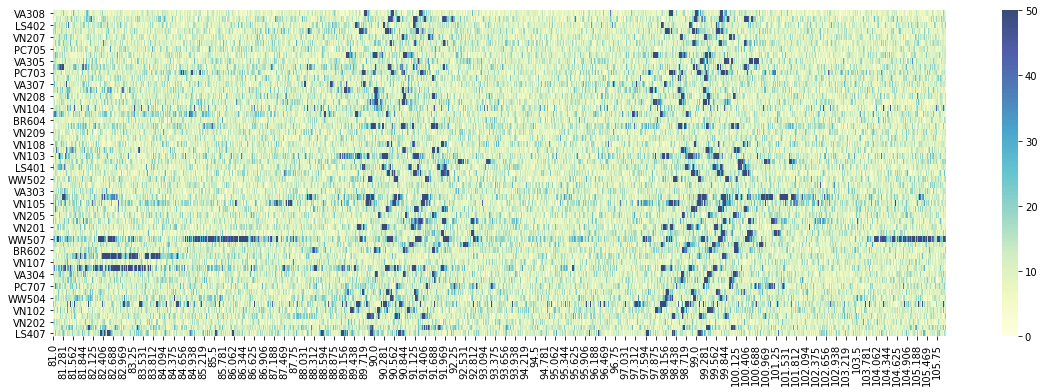

In [32]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
#plt.title(projectName + ' ' + sigName + ' for interval ' + interval_name)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

<AxesSubplot:>

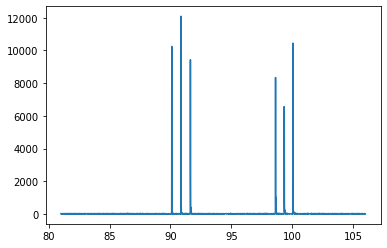

In [33]:
# first find tapping timing in one acc recording from delsys
sensorID = 'VN205'
sig_df = sub_sig[sensorID]
sig_df.plot() 

From a test plot of the whole acc signal, estimate the timing of the tapping cue in device time stamp values. Set this as initial_offset and iterate a few times to get this right to the correct offset time within tolerance. For this study we are getting aligning to within 100 ms, the best we can count on for the parallel recordings in the Movesense. 

This degree of alignment is within the range that can be fine tuned by the cross correlation if necessary. Because delsys has all the acc recordings on the same device time, we won't be adjusting individual sensor recordings from their respective suggested offsets.

6401
6401


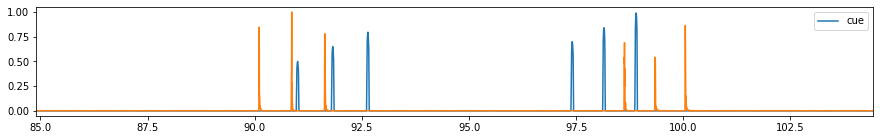

In [34]:
cues = Cue_template.copy()
cues['time_concert'] = cues.index
cues['DeviceTime'] = cues.index + initial_offset
cues.set_index('DeviceTime',inplace=True)

sig_ex = sub_sig[sensorID]/sub_sig[sensorID].max()
print(len(sig_ex))
sig_ID = sensorID
cuetype = 'spoint'

f = interpolate.interp1d(cues.index, cues[cuetype],fill_value='extrapolate')
cued = pd.DataFrame(index = sig_ex.index,data = f(np.array(sig_ex.index)),columns = ['cue'])
f = interpolate.interp1d(cues.index, cues['time_concert'],fill_value='extrapolate')
cued['time_concert'] = f(np.array(sig_ex.index))
print(len(cued))

cued.plot.line(y = 'cue')
sig_ex.plot(figsize=[15,2])
plt.xlim([cued.index[1000],cued.index[6000]])

plt.show()

In [35]:
cued['time_concert']

81.000    -10.000
81.004     -9.996
81.008     -9.992
81.012     -9.988
81.016     -9.984
            ...  
105.984    14.984
105.988    14.988
105.992    14.992
105.996    14.996
106.000    15.000
Name: time_concert, Length: 6401, dtype: float64

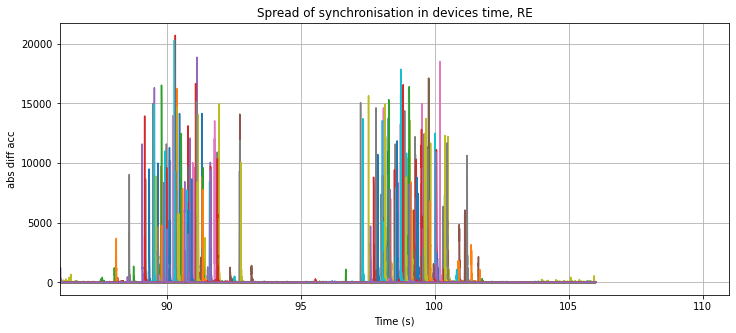

In [303]:
acc_day = sub_sig
acc_day.plot(figsize=(12,5),legend = False)
plt.ylabel('abs diff acc')
plt.title('Spread of synchronisation in devices time, '+ projectName)
plt.xlim([initial_offset -5 ,initial_offset + 20])
plt.xlabel('Time (s)')
plt.grid()
# plt.legend()
# plt.ylim([0,1000])
plt.savefig('./plots/'+projectName+'_uncorrected_taps.png',dpi = 300)

plt.show()

Initial automated alignment attempt and then correction phase

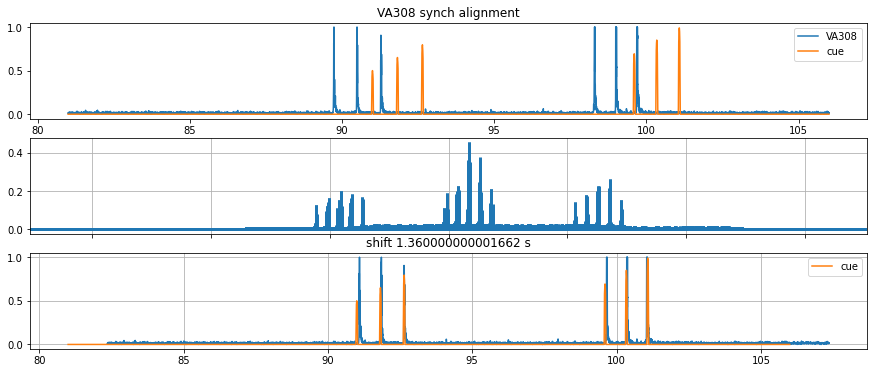

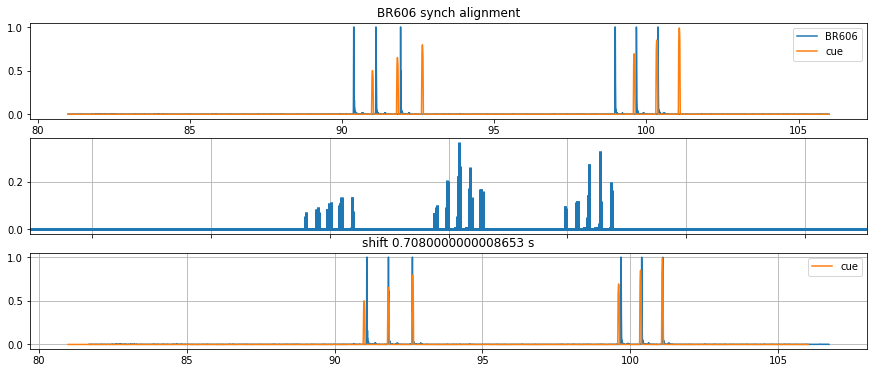

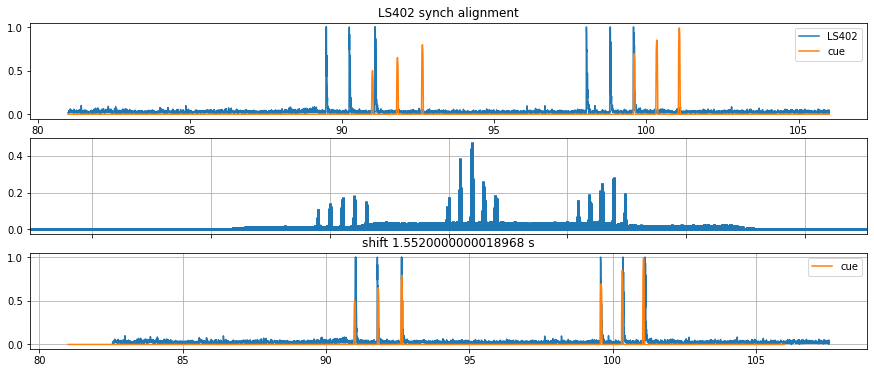

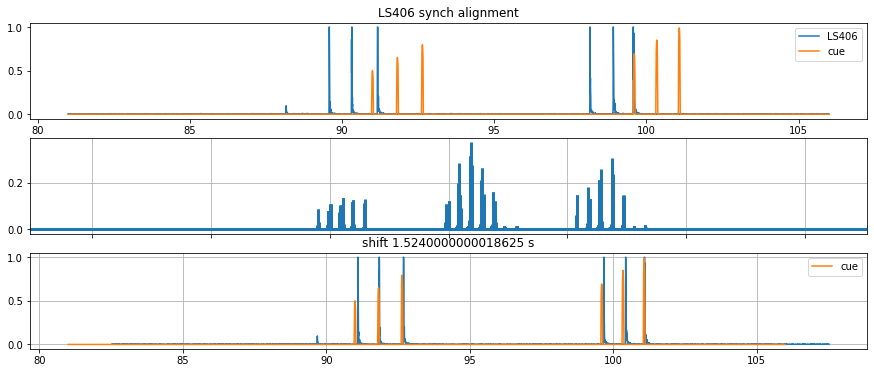

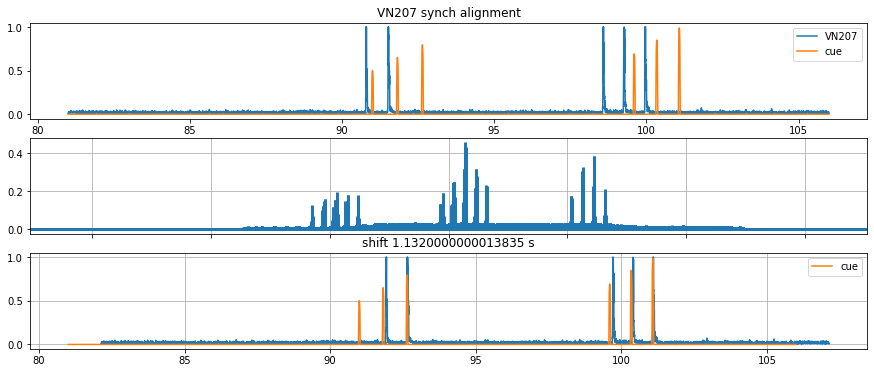

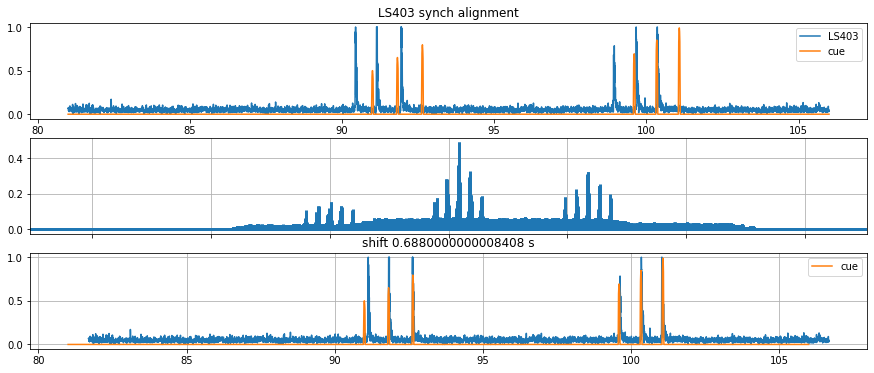

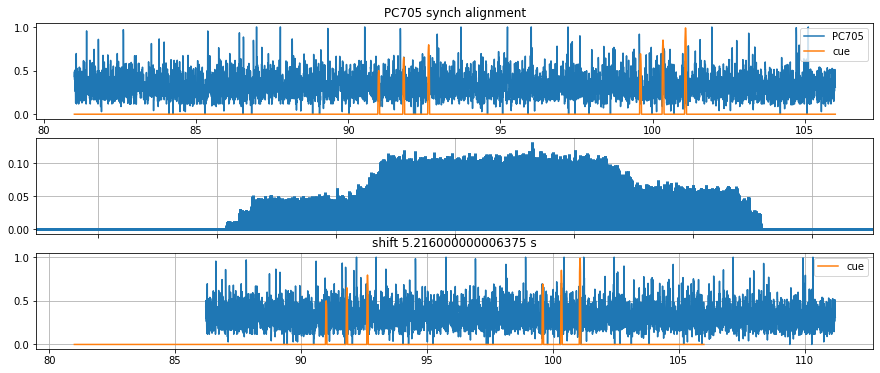

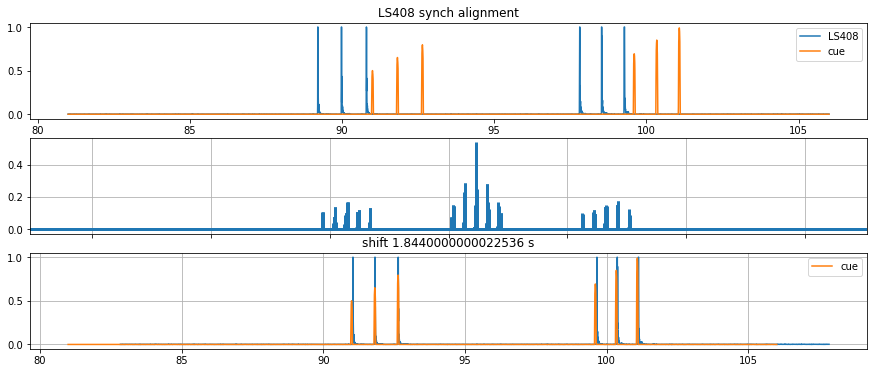

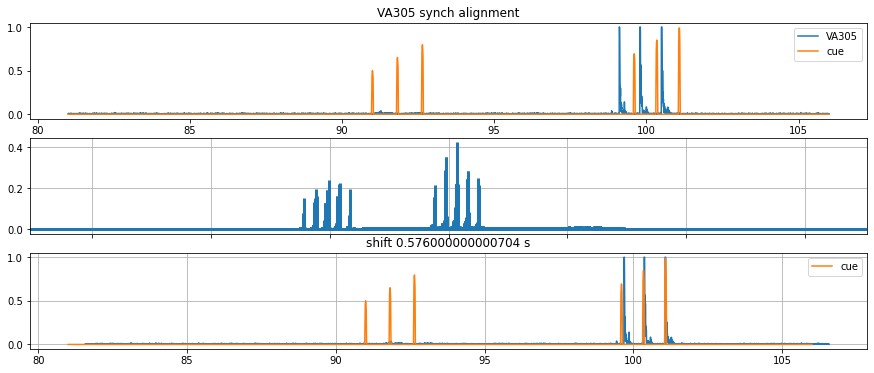

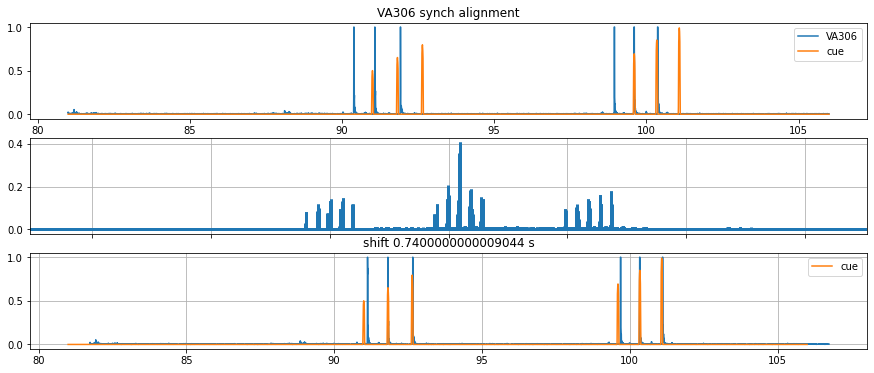

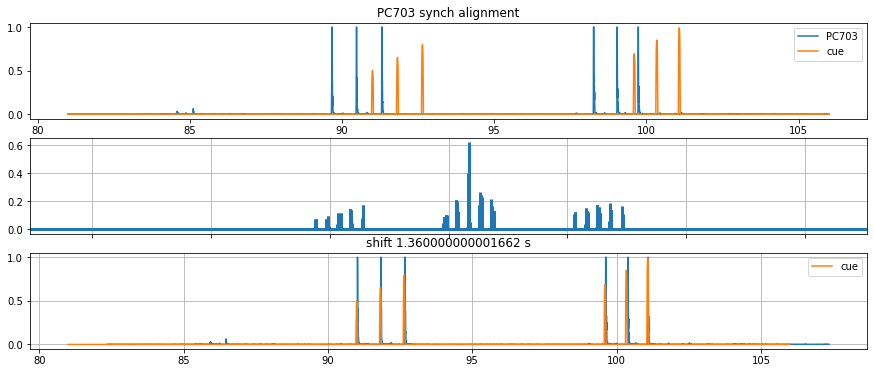

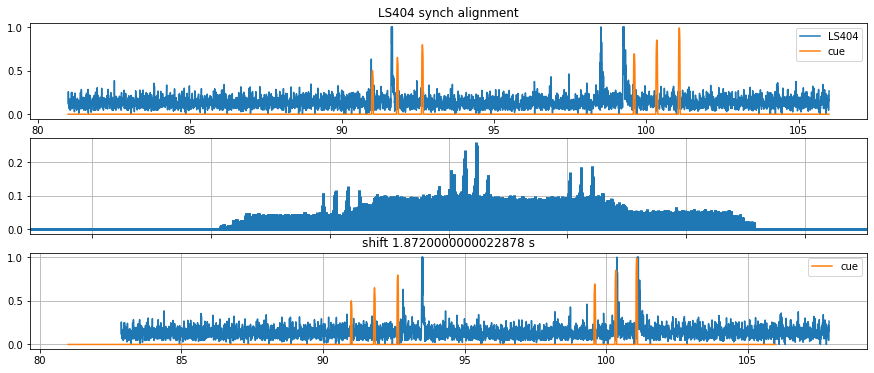

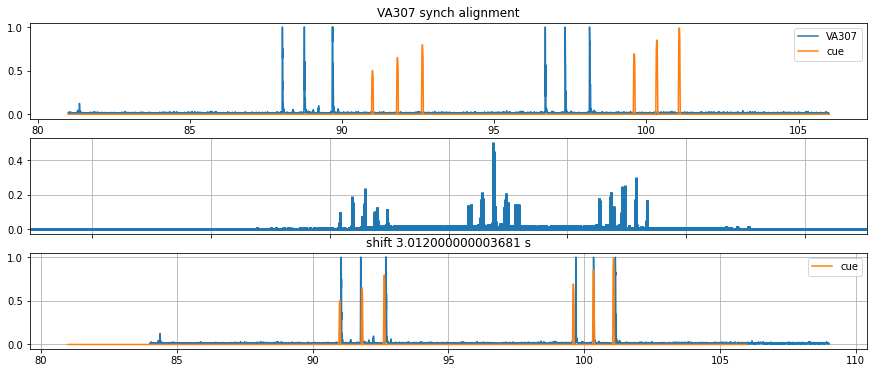

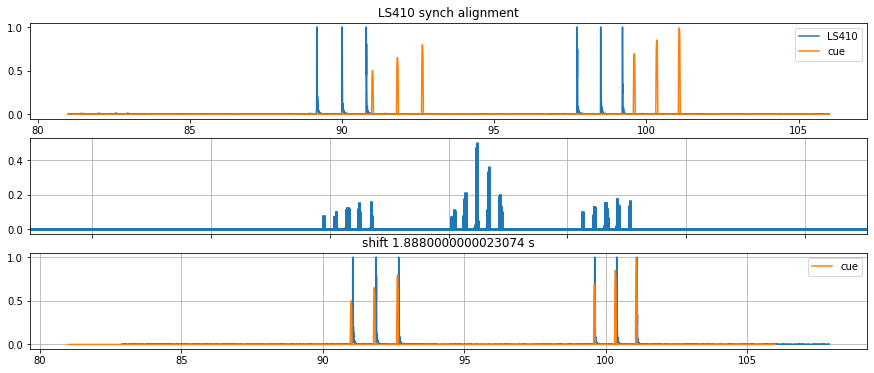

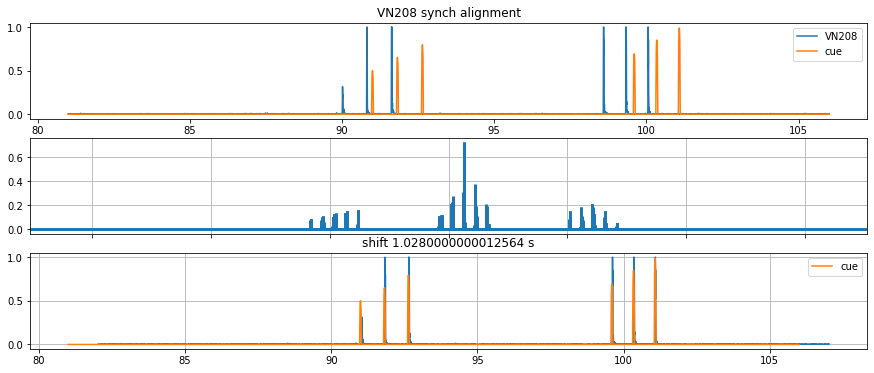

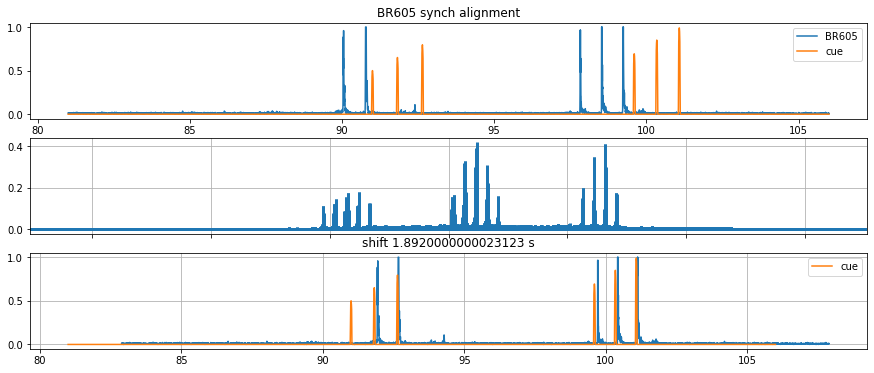

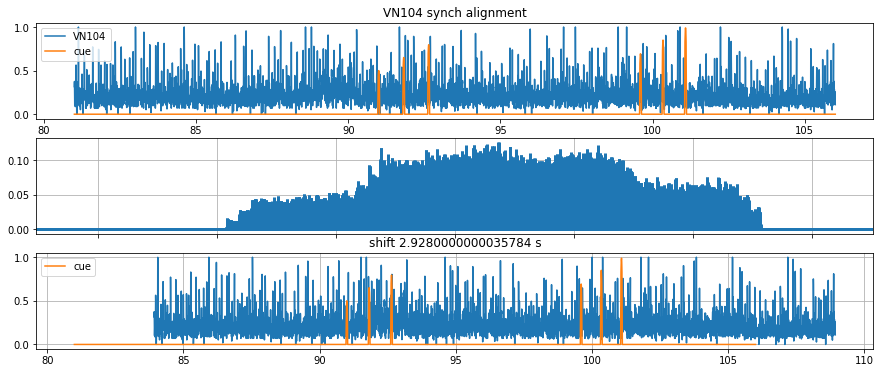

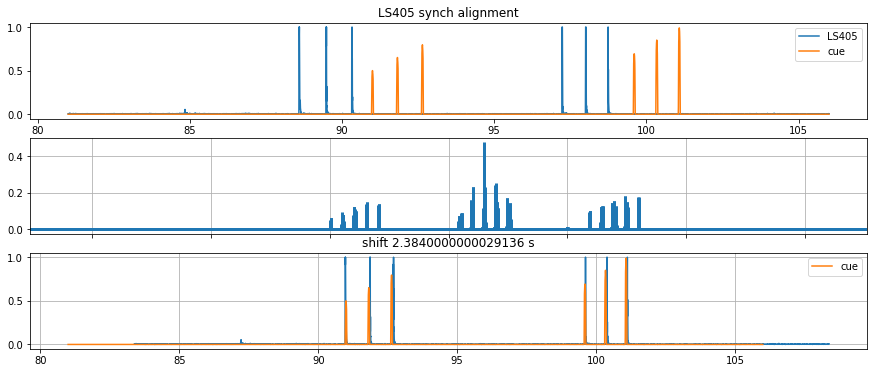

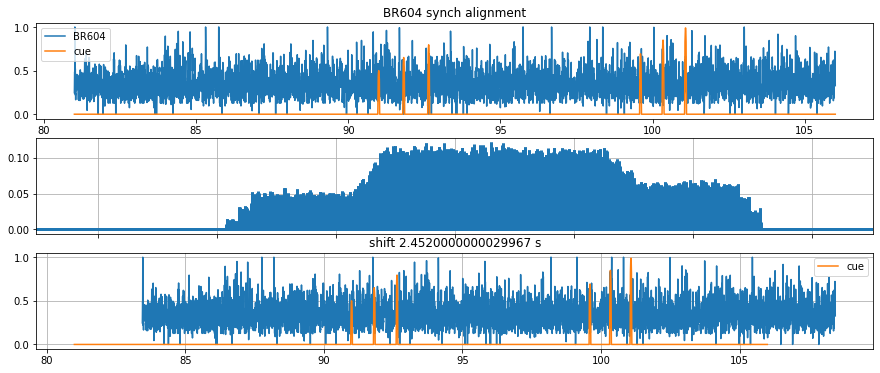

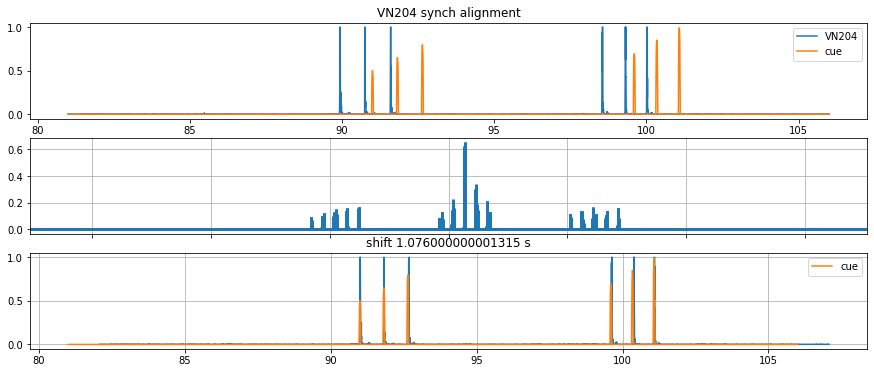

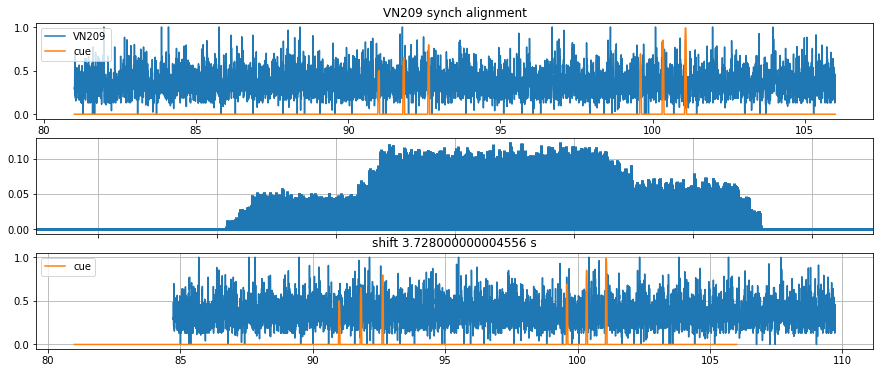

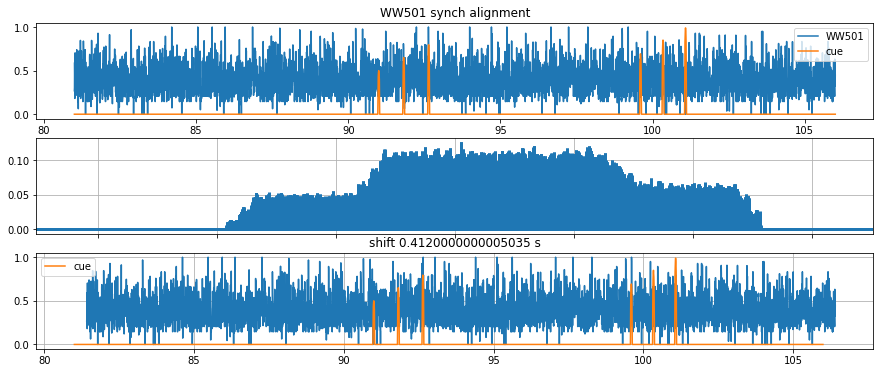

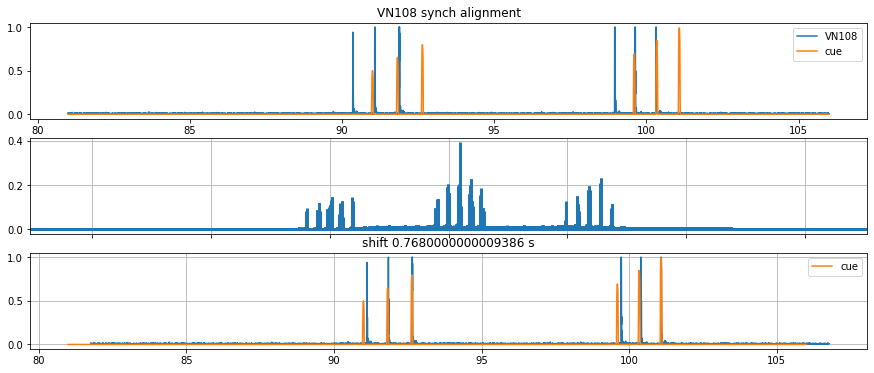

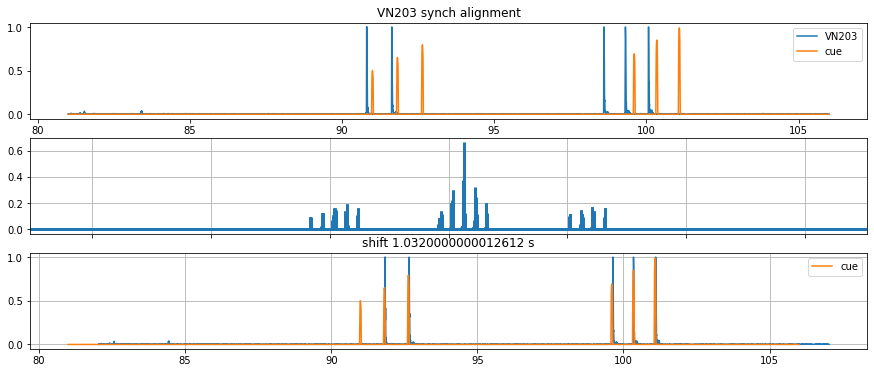

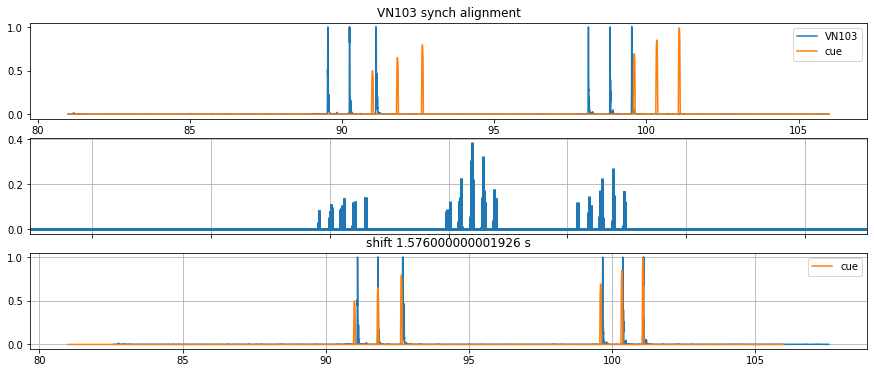

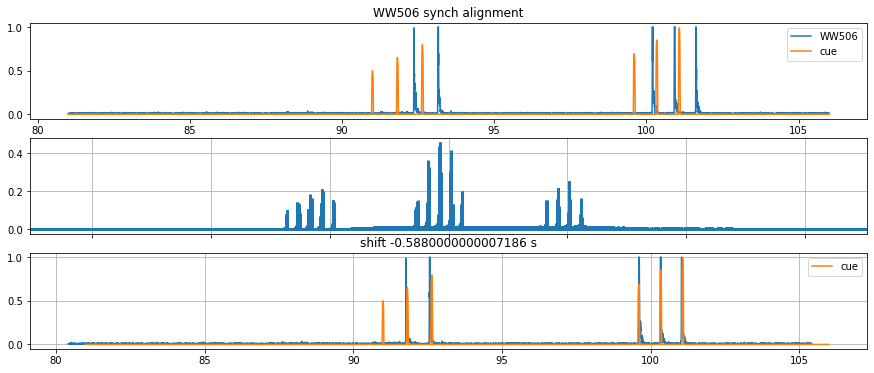

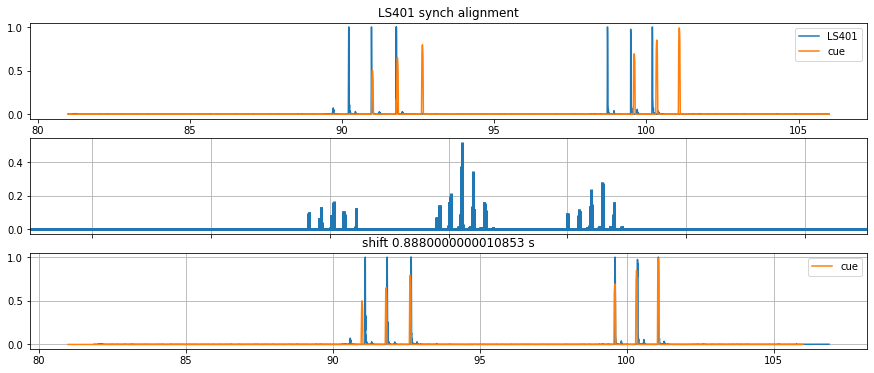

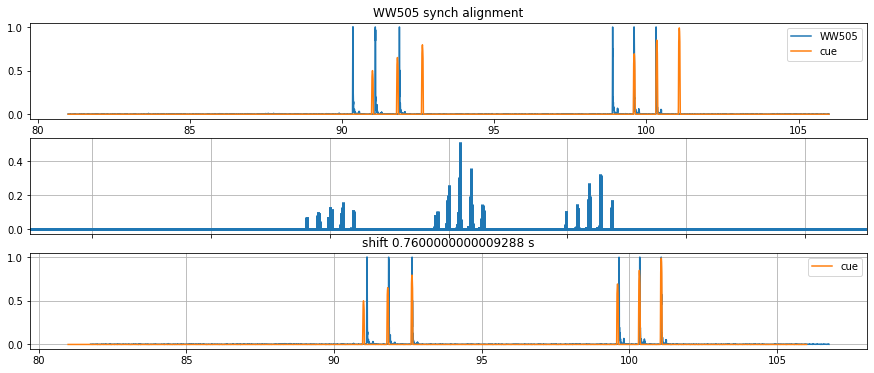

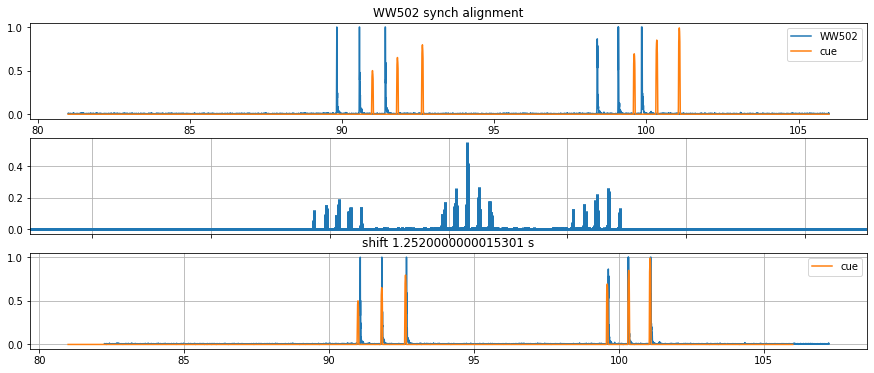

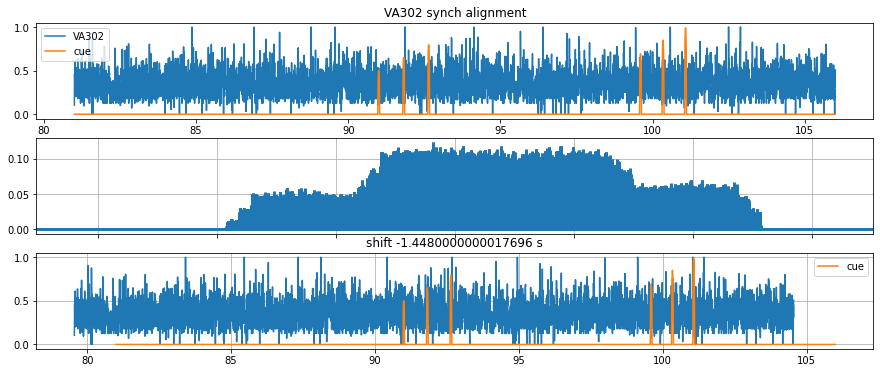

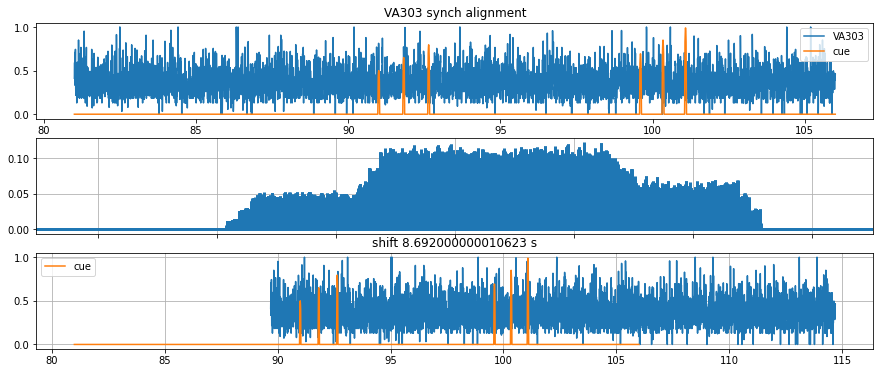

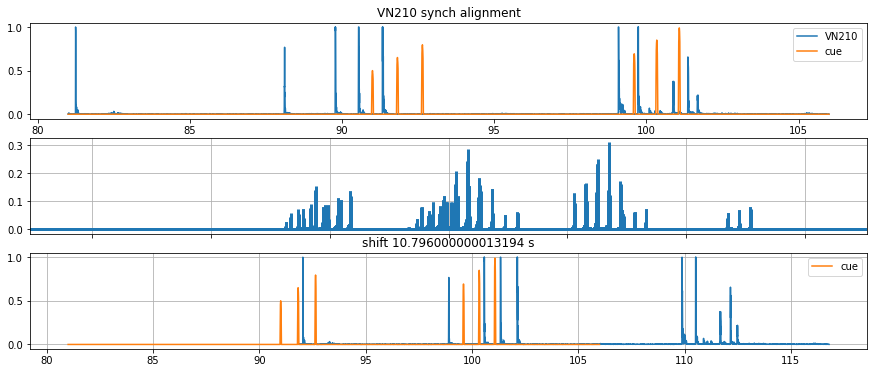

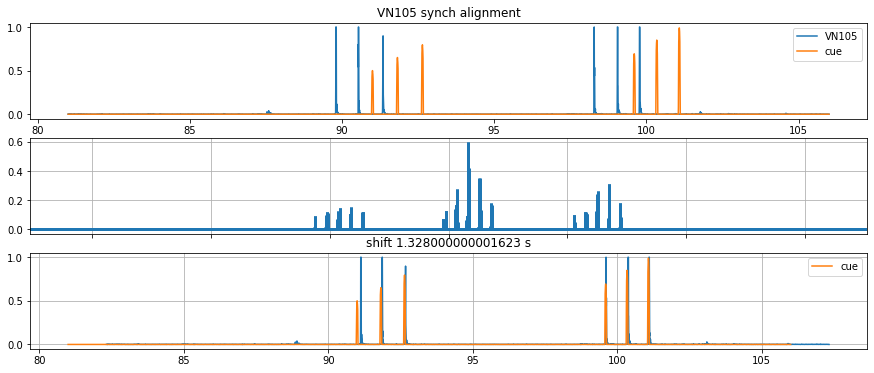

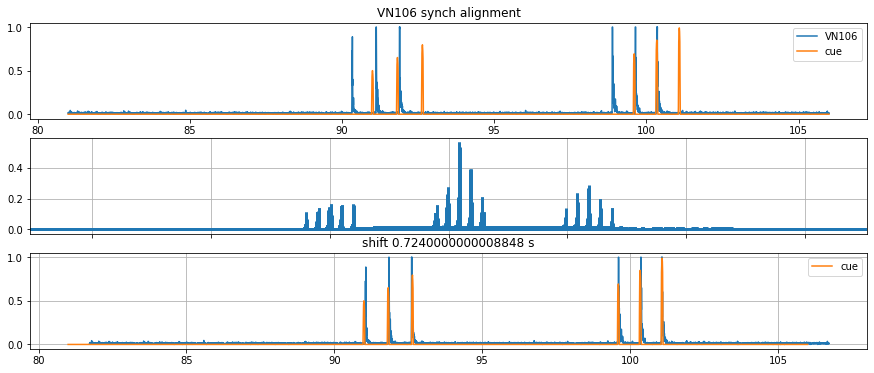

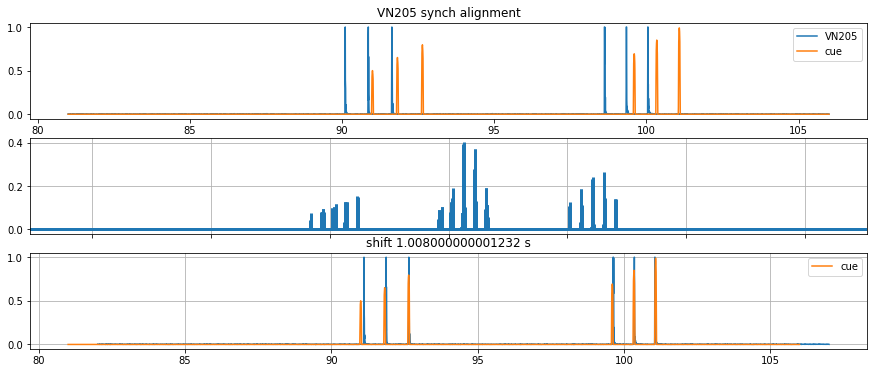

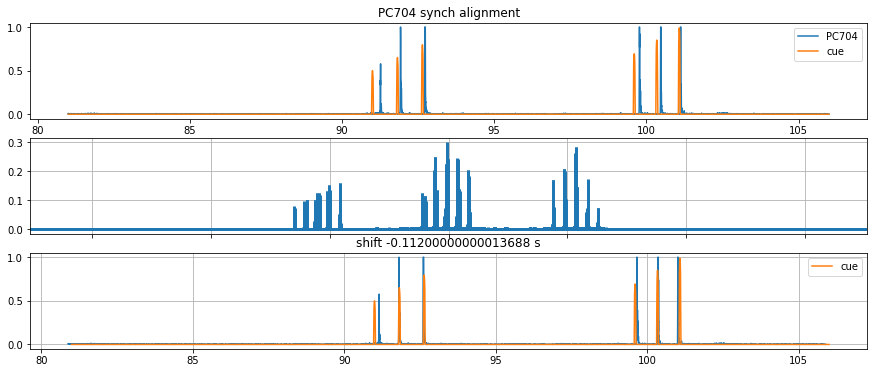

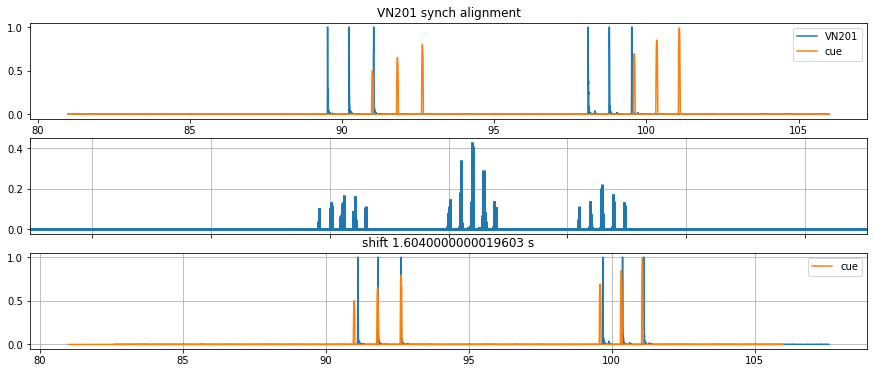

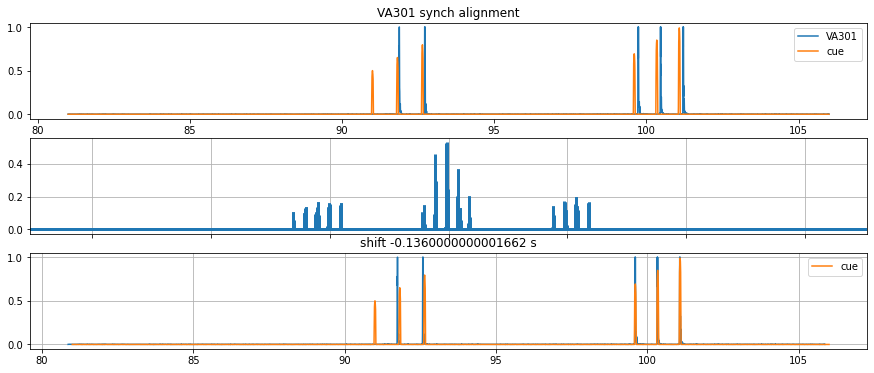

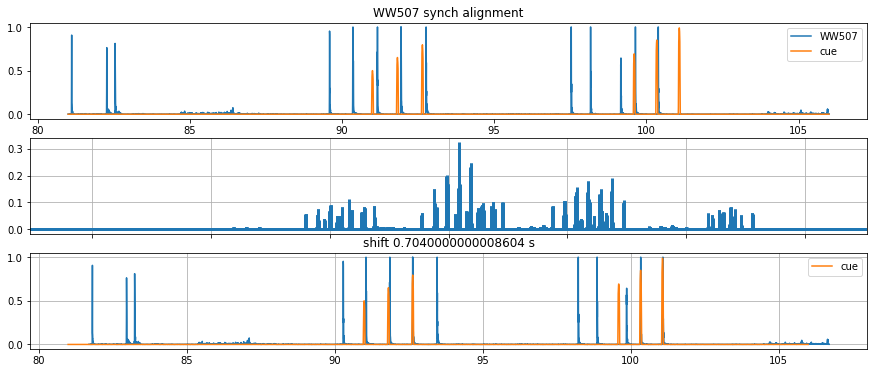

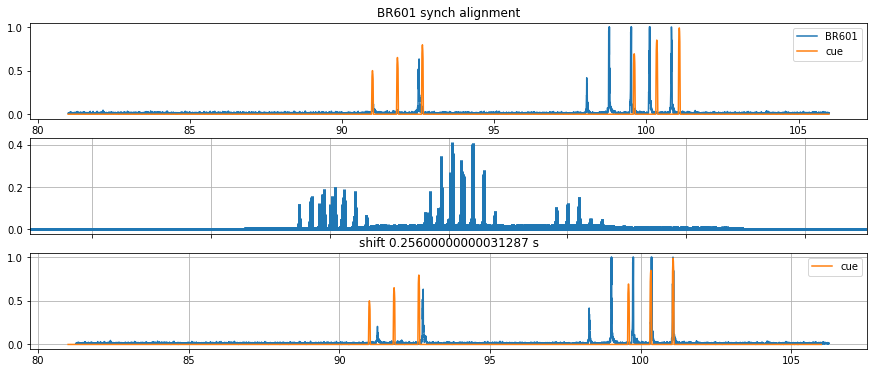

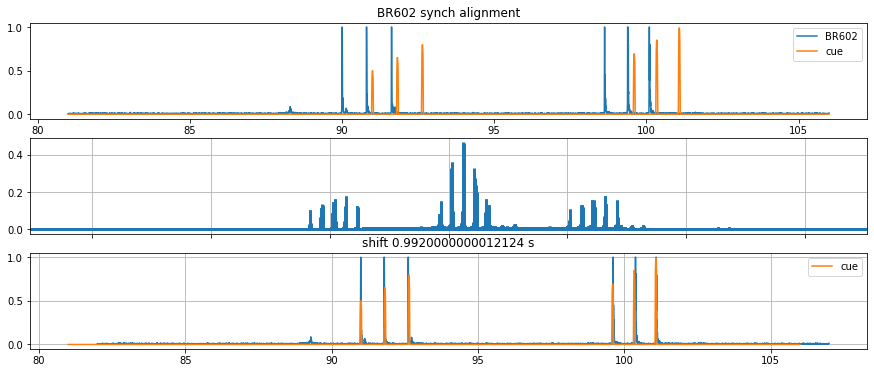

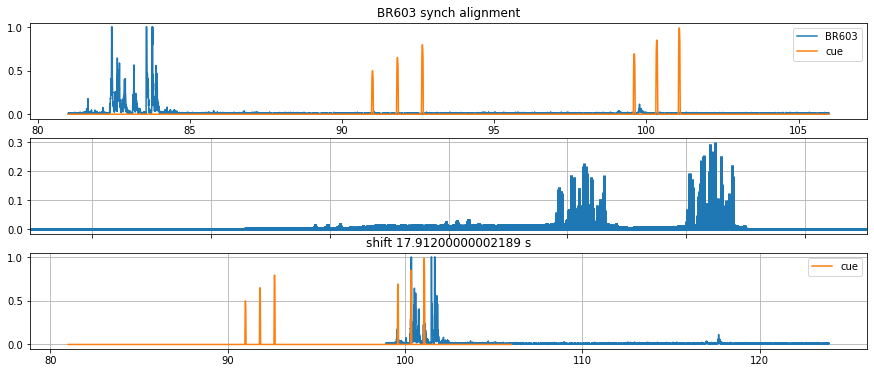

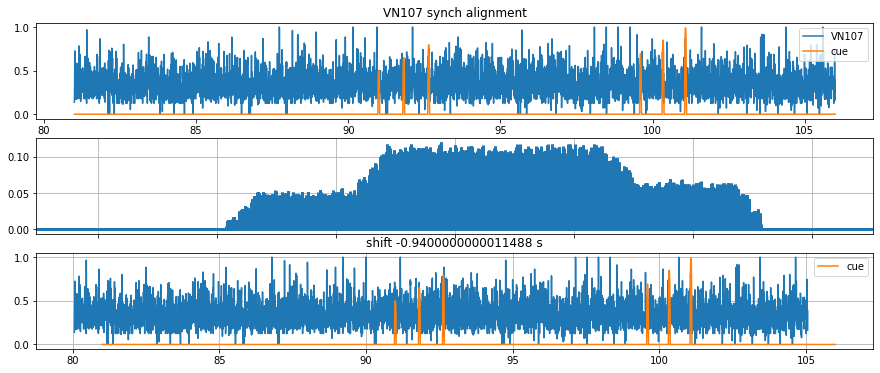

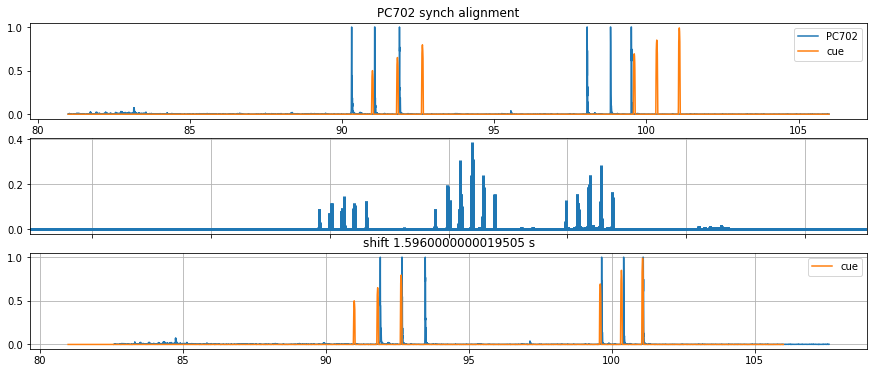

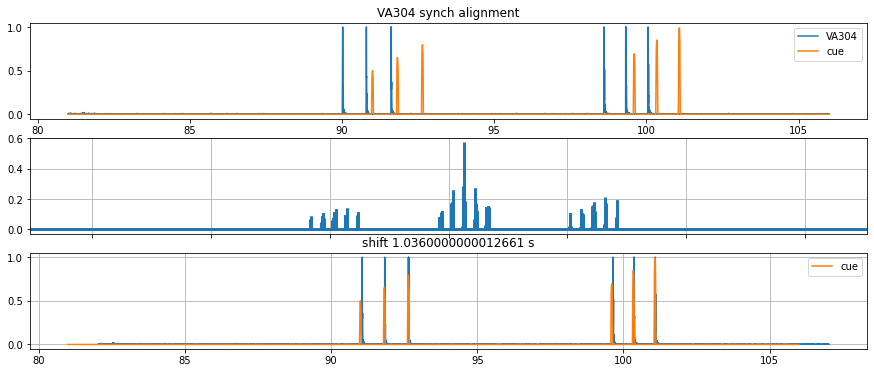

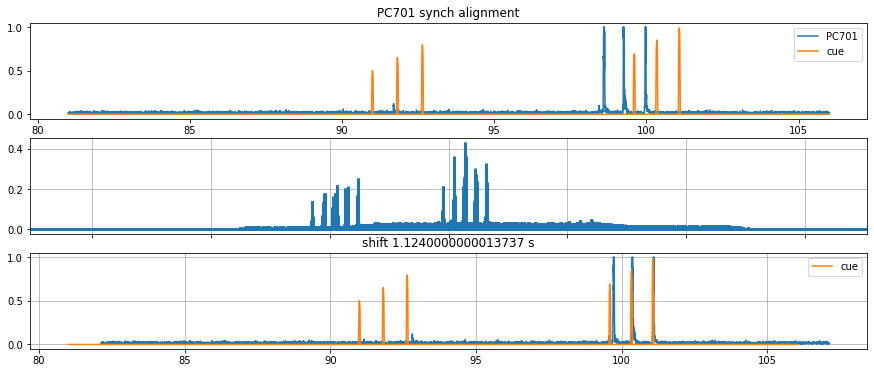

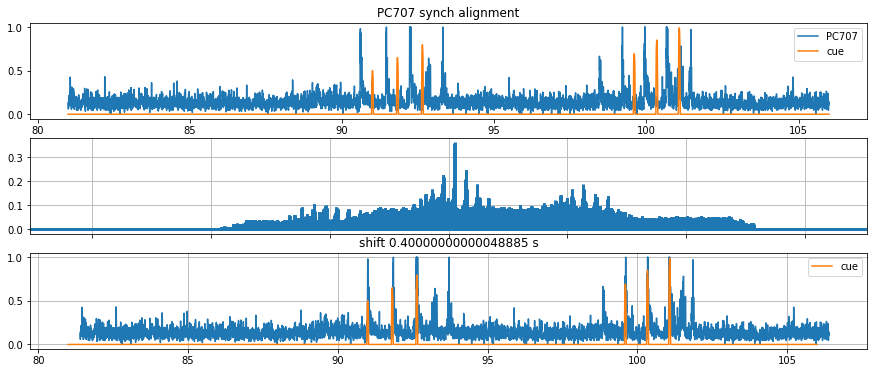

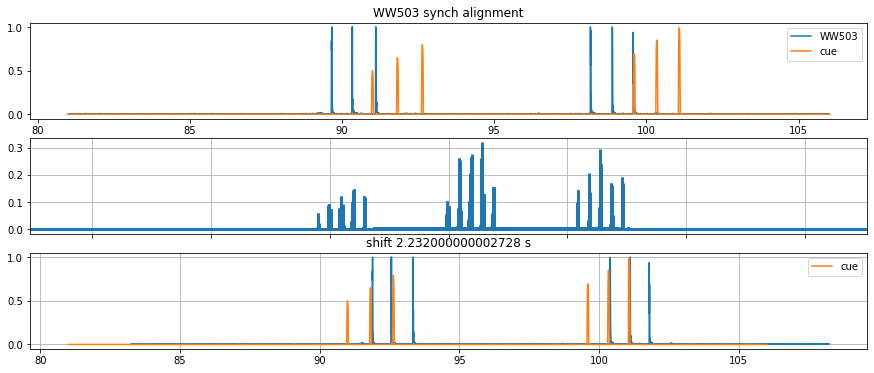

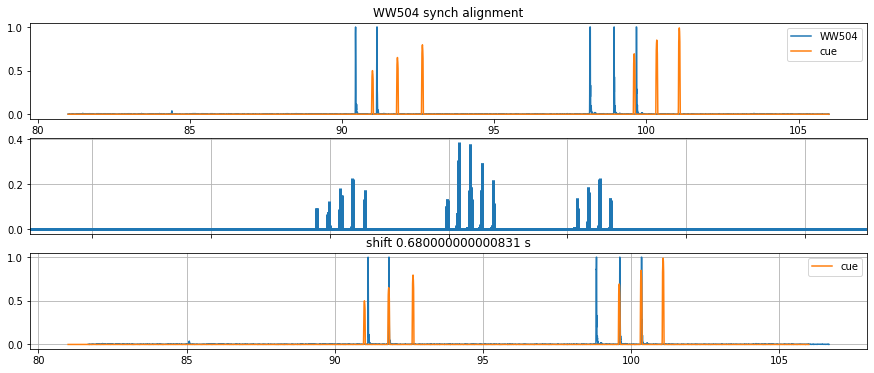

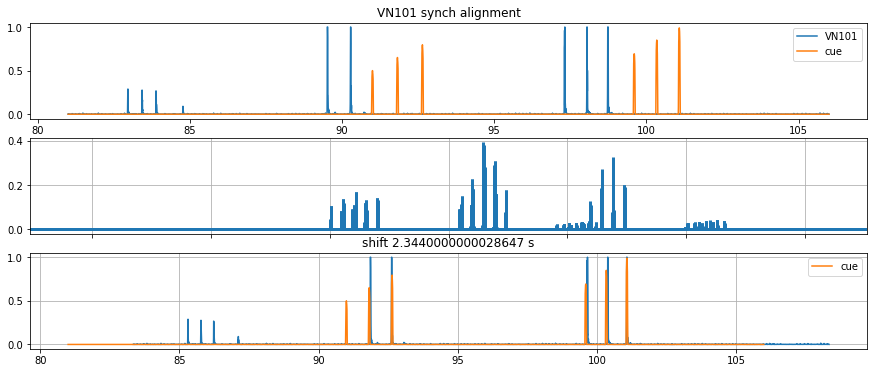

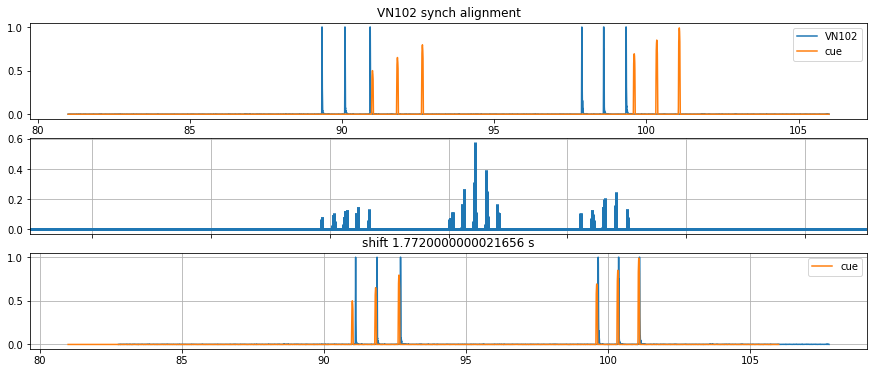

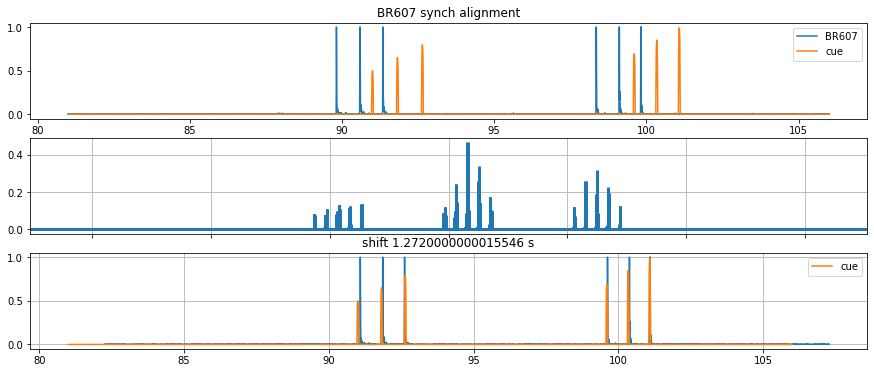

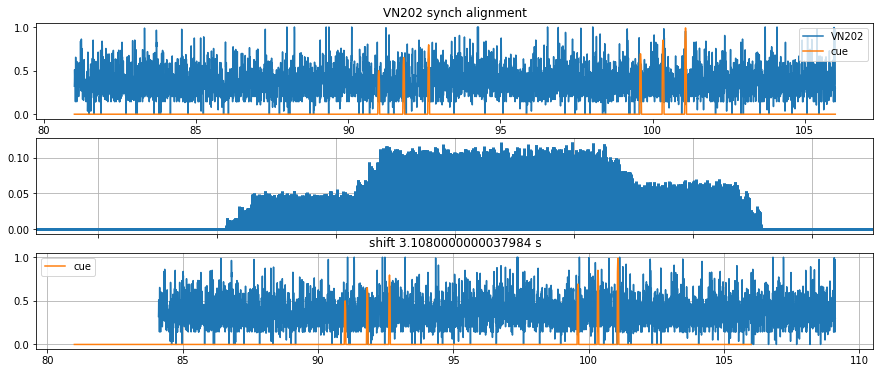

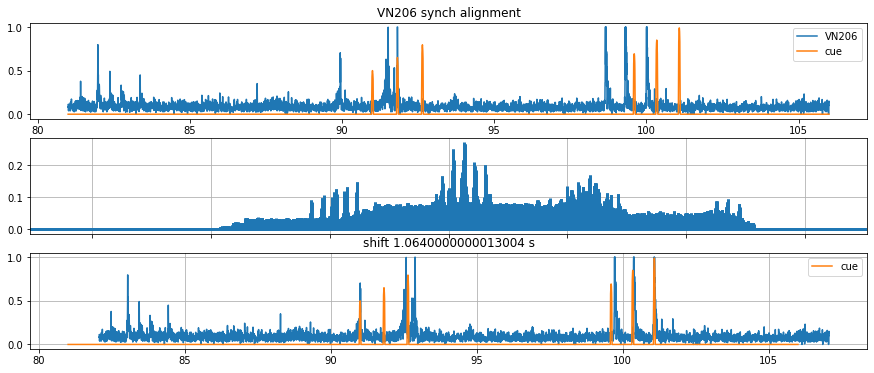

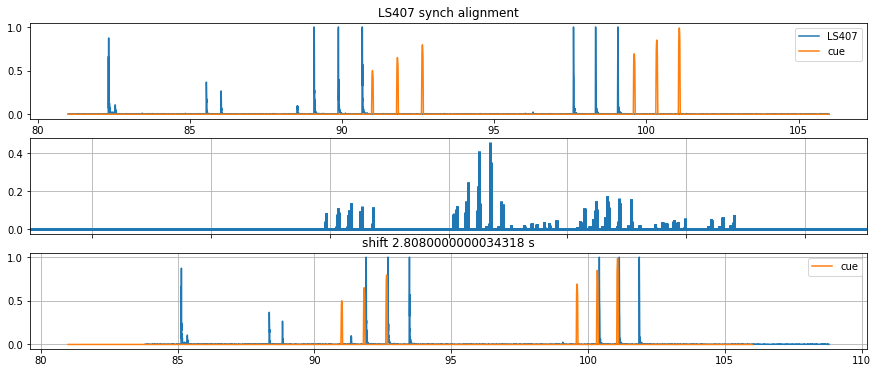

In [304]:
sig_exs = acc_day.loc[cued.index[0]:cued.index[-1]]
cols = sig_exs.columns
shifts = []
for c in cols:
    shifts.append(tap_cue_align(cued,sig_exs[c],c))

In [305]:
shift_df = pd.DataFrame.from_records(shifts)
shift_df.set_index('devID',drop=True,inplace=True)
print(shift_df['s_offset_time'].median())
shift_df.to_csv('./out_data/initial_synch_'+ projectName + '2_offsets.csv')

1.2520000000015301


In [306]:
shift_df

,s_corr0,s_corr_offset,s_offset_samples,s_offset_time,Length_xcorr_samples,Length_xcorr_time,auto_offset_time,Full_CCC
devID,,,,,,,,
VA308,0.025188,0.455089,340,1.360,12801,51.204,1.360,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
BR606,0.002985,0.365353,177,0.708,12801,51.204,0.708,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
LS402,0.152232,0.473701,388,1.552,12801,51.204,1.552,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
LS406,0.064585,0.373076,381,1.524,12801,51.204,1.524,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
VN207,0.030374,0.458186,283,1.132,12801,51.204,1.132,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
LS403,0.124001,0.488984,172,0.688,12801,51.204,0.688,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
PC705,0.099024,0.131785,1304,5.216,12801,51.204,5.216,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
LS408,0.003212,0.538150,461,1.844,12801,51.204,1.844,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."
VA305,0.012580,0.424804,144,0.576,12801,51.204,0.576,"([-6400, -6399, -6398, -6397, -6396, -6395, -6..."


# Manual correction of initial synchronisation correction 
The auto alignment is about 40 % correct. Needs supervision to get around poor tapping and other errors.

This next sequence of cells go through synch cues one at a time and allow for their values to be corrected in the shifts DataFrame.

In [307]:
i = 0

In [444]:
i+=1

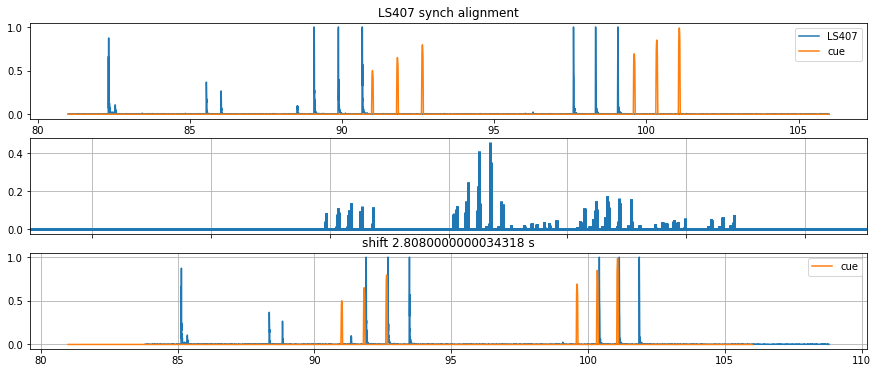

In [445]:
c = cols[i]
s = tap_cue_align(cued,sig_exs[c],c)


In [446]:
##### local peaks in CCC
CCC = s['Full_CCC']
mid_off = int((s['Length_xcorr_samples']-1)/2)
ccthresh = 0.2
V =np.clip(CCC[1], ccthresh, 1)
pks = pd.DataFrame()
pks['ind'] = argrelextrema(V, np.greater)[0]
pks['corr']=V[argrelextrema(V, np.greater)]
pks['shift'] = argrelextrema(V, np.greater)[0]-mid_off
pks

,ind,corr,shift
0,6725,0.250059,325
1,6911,0.412865,511
2,7102,0.457357,702


In [447]:
#offs = s['s_offset_samples']
offs = 6911 - mid_off
slips = offs + mid_off #-1
print([CCC[0][slips],CCC[1][slips]])

# sub_range = np.arange(0,40)+slips - 10
# [CCC[0][sub_range],CCC[1][sub_range]]

[511, 0.4128652230135072]


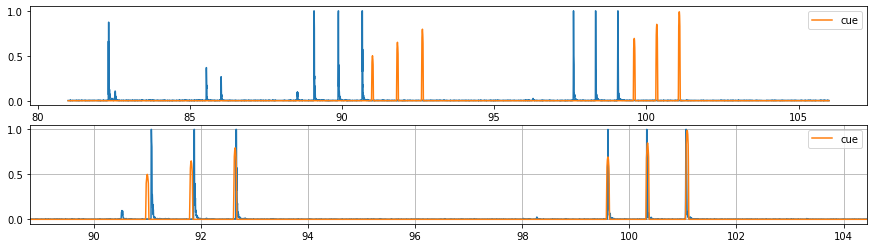

In [448]:
signal = sig_exs[c].copy()
    # make the signal excerpt corr compatible. Inclusing cutting the extreme peaks
signal[signal.isna()] = 0
M = signal.quantile(0.998)
signal = signal/M
signal[signal>1] = 1

fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(211)
signal.plot(ax=ax1)
cued.plot.line(y='cue',ax=ax1)
signal.index = signal.index + sample_period*CCC[0][slips]

ax1 = plt.subplot(212)
signal.plot(ax=ax1)
cued.plot.line(y='cue',ax=ax1)
plt.xlim([cued.index[2000],cued.index[6000]])
ax1.grid(True)
#plt.saveas('')
plt.show()

In [451]:
#### correct record of alignment
shift_true = slips #np.argmax(CCC1[1])
print([str(c),shift_true,CCC[0][shift_true], (sample_period*CCC[0][shift_true]), len(CCC[0]),len(CCC[0])*sample_period]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
shift_df.loc[c,'s_corr_offset'] =CCC[1][shift_true]
shift_df.loc[c,'s_offset_samples'] = offs 
shift_df.loc[c,'s_offset_time'] = sample_period*CCC[0][shift_true]
shift_df.loc[c, "dt_offset"] = dev_int_s_time + pd.to_timedelta(sample_period*shift_true,unit='s')
shift_df.loc[c,:]

['LS407', 6911, 511, 1.99609375, 12801, 50.00390625]


s_corr0                                                          0.004675
s_corr_offset                                                    0.412865
s_offset_samples                                                      511
s_offset_time                                                    1.996094
Length_xcorr_samples                                                12801
Length_xcorr_time                                                  51.204
auto_offset_time                                                    2.808
Full_CCC                ([-6400, -6399, -6398, -6397, -6396, -6395, -6...
dt_offset                             2023-02-15 10:25:17.996093750+00:00
Name: LS407, dtype: object

In [450]:
#### correct record of alignment by REMOVING CUE ESTIMATE BECAUSE THERE WERE NO TAPS
shift_true = np.nan #np.argmax(CCC1[1])
print([str(c),shift_true]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
shift_df.loc[c,'s_corr_offset'] =np.nan
shift_df.loc[c,'s_offset_time'] = np.nan
shift_df.loc[c,:]

['LS407', nan]


s_corr0                                                          0.004675
s_corr_offset                                                         NaN
s_offset_samples                                                      511
s_offset_time                                                         NaN
Length_xcorr_samples                                                12801
Length_xcorr_time                                                  51.204
auto_offset_time                                                    2.808
Full_CCC                ([-6400, -6399, -6398, -6397, -6396, -6395, -6...
dt_offset                             2023-02-15 10:25:17.996093750+00:00
Name: LS407, dtype: object

##### Corrected synchronisation offsets
The index_offset field (corrected to "auto_offset_time") actually retains the initial offset, so we can use discrepensy with s_offset_time to note which had to be adjusted.

the additional field of 'synch_dev_time' marks the time of the synchronisation taps start (tap 1)  in the raw recordings device clock times. Corrections can then be performed from here to whatever gets defined as the real synch time.

In [452]:
shift_df['synch_dev_time'] = s_time + pd.to_timedelta(initial_offset + shift_df['s_offset_time'],unit='s')
shift_df.to_csv('./out_data/CorrectedEQ_synch_'+ projectName + '_offsets.csv')

In [453]:
shift_df.mean()

<ipython-input-453-167145b6b42b>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  shift_df.mean()


s_corr0                     0.049663
s_corr_offset               0.454740
s_offset_samples          431.272727
s_offset_time               1.169928
Length_xcorr_samples    12801.000000
Length_xcorr_time          51.204000
auto_offset_time            1.925018
dtype: float64

# Check aligning quality acheived

In [273]:
synch_times = {'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'RD':pd.to_datetime('2023-02-15 12:05:36.897+0100'), # 97.0 
                 'C1':pd.to_datetime('2023-02-16 9:33:18.324+0100'),
                 'C2':pd.to_datetime('2023-02-16 11:16:22.697+0100'),
                 'C3':pd.to_datetime('2023-02-17 9:30:51.841+0100'),
                 'C4':pd.to_datetime('2023-02-17 11:16:29.298+0100'),
                 'C5':pd.to_datetime('2023-02-18 16:10:29.583+0100')}

In [274]:
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']

In [275]:
projectName = 'RE'
path = '../Data/Equivital/Synching/' + projectName + sep
sep = '/'

# signal File type and column name (multi sample)
signal_file_type = 'FASTACC'
sample_period = 1.0/256 # seconds 
interval_name = 'Experiment Alignement'
sigName = 'ACC'
[s_time,e_time] = synch_intervals[projectName]
dur = (e_time - s_time).total_seconds()
time_s =  np.round(np.arange(0,dur,sample_period),3)

synch_dt = synch_times[projectName]

time_dt = s_time + pd.to_timedelta(time_s,unit='s')
df_sig = pd.DataFrame(index = time_dt,columns=player_order)
df_shig = pd.DataFrame(index = time_dt,columns=player_order)

In [276]:
df_datafiles = qex.qiosk_recordings(path,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
s_files = df_datafiles.copy()

In [277]:
shifts = pd.read_csv('./out_data/CorrectedEQ_synch_'+ projectName + '_offsets.csv')
shifts['synch_dev_time'] = pd.to_datetime(shifts['synch_dev_time'])
shifts.set_index('devID',inplace=True)
shifts['synch_dev_time'].mean()

Timestamp('2023-02-15 10:25:26.502609664+0000', tz='UTC')

In [278]:
# for acceleration
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = i
    dev_offset = (synch_times[projectName].tz_convert('UTC')- shifts.loc[PartName,'synch_dev_time']).total_seconds()#.total_seconds()# approx offset of cue and signal


    sigFileLoc = []
    matched = qex.matched_files(dataFile,path,sep)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime']) 
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        
        f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig
            
            if not math.isnan(dev_offset):
                sig_t -= dev_offset
                f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
                new_sig = f(time_s)
                if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
                    df_shig.loc[:,PartName] = new_sig
            else: # if the signal can't be synched, skip it.
                df_shig.loc[:,PartName] = np.nan

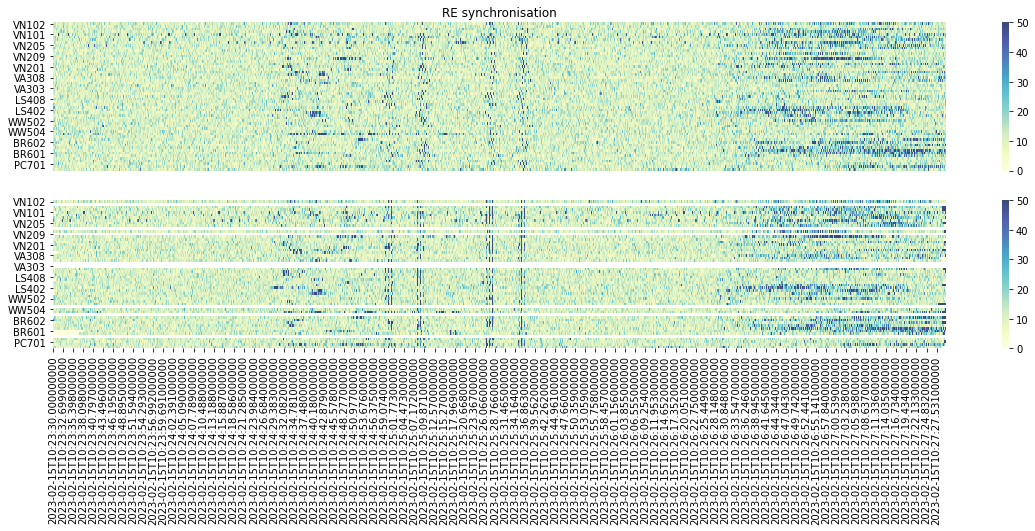

In [281]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [20,6])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
ax1.set_title(projectName + ' synchronisation')
ax1.set_xticks([])
chart = sns.heatmap(data=df_shig.transpose(), ax=ax2,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
#ax2.set_xticks([])
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_synch_cue.png',dpi = 300)
plt.show()

In [ ]:
Timestamp('2023-02-15 10:25:01.00+0000', tz='UTC')


## same day corrections
How is alignment from C2 on C1. C3 on C4?

In [1949]:
projectName = 'C3'
path = '../Data/Equivital/Synching/' + projectName + sep
sep = '/'

# signal File type and column name (multi sample)
signal_file_type = 'FASTACC'
sample_period = 1.0/256 # seconds 
interval_name = 'Lydo_3_Synch'
sigName = 'ACC'
[s_time,e_time] = synch_intervals[projectName]
dur = (e_time - s_time).total_seconds()
time_s =  np.round(np.arange(0,dur,sample_period),3)

time_dt = s_time + pd.to_timedelta(time_s,unit='s')
df_sig = pd.DataFrame(index = time_dt,columns=player_order)
df_shig = pd.DataFrame(index = time_dt,columns=player_order)
df_shigalt = pd.DataFrame(index = time_dt,columns=player_order)

In [1950]:
df_datafiles = qex.qiosk_recordings(path,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
s_files = df_datafiles.copy()

In [1951]:
synch_dtA = synch_times[projectName]
synch_dtB = synch_times['C4']

shiftsA = pd.read_csv('./out_data/CorrectedEQ_synch_C3_offsets.csv')
shiftsA['synch_dev_time'] = pd.to_datetime(shiftsA['synch_dev_time'])
shiftsA.set_index('devID',inplace=True)
shiftsA['synch_dev_time'].mean()

shiftsB = pd.read_csv('./out_data/CorrectedEQ_synch_C4_offsets.csv')
shiftsB['synch_dev_time'] = pd.to_datetime(shiftsB['synch_dev_time'])
shiftsB.set_index('devID',inplace=True)
shiftsB['synch_dev_time'].mean()

Timestamp('2023-02-17 10:16:29.298413056+0000', tz='UTC')

In [1952]:
# for acceleration
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = i
    dev_offsetA = (synch_dtA.tz_convert('UTC')- shiftsA.loc[PartName,'synch_dev_time']).total_seconds()
    dev_offsetB = (synch_dtB.tz_convert('UTC')- shiftsB.loc[PartName,'synch_dev_time']).total_seconds()


    sigFileLoc = []
    matched = qex.matched_files(dataFile,path,sep)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime']) 
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        
        f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig
            
            if not math.isnan(dev_offsetA):
                sig_t -= dev_offsetA
                f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
                new_sig = f(time_s)
                if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
                    df_shig.loc[:,PartName] = new_sig
            else: # if the signal can't be synched, skip it.
                df_shig.loc[:,PartName] = np.nan
                
            if not math.isnan(dev_offsetB):
                sig_t -= dev_offsetB
                f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
                new_sig = f(time_s)
                if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
                    df_shigalt.loc[:,PartName] = new_sig
            else: # if the signal can't be synched, skip it.
                df_shigalt.loc[:,PartName] = np.nan

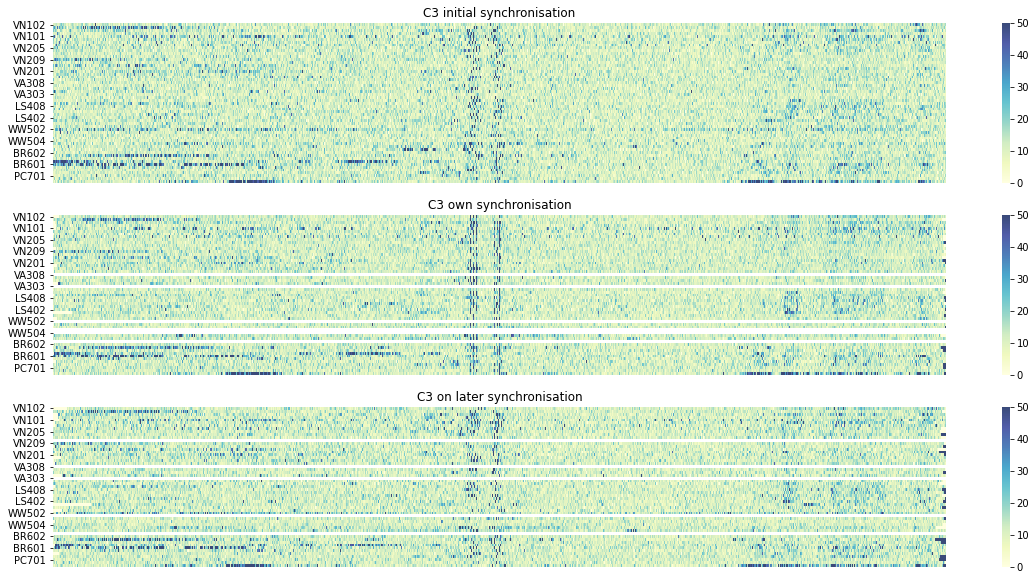

In [1953]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize = [20,10])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
ax1.set_title(projectName + ' initial synchronisation')
ax1.set_xticks([])
chart = sns.heatmap(data=df_shig.transpose(), ax=ax2,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
ax2.set_title(projectName + ' own synchronisation')
ax2.set_xticks([])
chart = sns.heatmap(data=df_shigalt.transpose(), ax=ax3,vmin=0, vmax=50, cbar=True,cmap="YlGnBu",alpha=0.8)
ax3.set_title(projectName + ' on later synchronisation')
ax3.set_xticks([])
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_synch_cue_compared.png',dpi = 300)
plt.show()

In [1962]:
shiftsA['synch_dev_time'].std()

Timedelta('0 days 00:00:01.021987542')

In [1961]:
(shiftsB['synch_dev_time']-shiftsA['synch_dev_time']).std()

Timedelta('0 days 00:00:00.221681720')

The standard deviation in misalignment between devices and concert time is down from a second without synchronisation to a quarter of a second with a cue from 100 minutes ago.

Some of the difference between first and second synch times is from misalignments. Some will be from clock drift. These can be improved with excerpts from other parts of the concerts.

# Last tests and Corrections

The synchronisation of equivital measurements can be tested against clapping music. Extract clapping for each concert and check:

1. Alignment on 5 rated alignments for drift
2. Alignment on 4 and 3 rated for confirmation of beat selection and alignment.
3. Alignment on 2 and 1 (who was really absent)

In [ ]:
'/Users/finn/Desktop/Current_Projects/Stavanger/Data/Equivital/Reic/C2/'